# Grads in pytorch



In [30]:
import torch

x = torch.tensor([2, 1.2, 0, 4],requires_grad= True)

y = x*x
z = y.sum()

print("x =",x)
print("x.grad = ",x.grad) # grad is none

z.backward()
print("y: ",y,"y.grad = ", y.grad) # lead to warning
print("x: ",x,"x.grad = ", x.grad)


x = tensor([2.0000, 1.2000, 0.0000, 4.0000], requires_grad=True)
x.grad =  None
y:  tensor([ 4.0000,  1.4400,  0.0000, 16.0000], grad_fn=<MulBackward0>) y.grad =  None
x:  tensor([2.0000, 1.2000, 0.0000, 4.0000], requires_grad=True) x.grad =  tensor([4.0000, 2.4000, 0.0000, 8.0000])


<ipython-input-30-0114cc2a6f9f>:12: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print("y: ",y,"y.grad = ", y.grad) # lead to warning


loss.backward() computes dloss/dx for every parameter x which has requires_grad=True.

These are accumulated into x.grad for every parameter x.
In pseudo-code:  x.grad += dloss/dx

z = loss

We want dz/dx

dz/dx = dz/dy * dy/dx

z = y0 + y1 + y2 + y3

dz/dy = [1,1,1,1] dz equal to  loss

y = x^2

dy/dx = 2x

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=6721a20ff6abea7c1fb797fceca62498b096e23c77511cac5d849a0e03ea1dbf
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


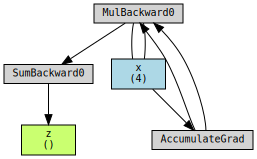

In [27]:
from torchviz import make_dot

y = x*x
z = y.sum()
make_dot(z, params={'x':x, 'y':y, 'z':z}, show_saved=True)#, show_attrs=True, show_saved=True)

## Let's call backward second time

it's produce an error


In [31]:
try:
  z.backward()
except Exception as e:
  print("ERROR")
  print(e)

ERROR
Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


In [ ]:
x = torch.tensor([2,1.2,0,4],requires_grad= True)
print ("X = ",x)

y = x*x

# Now grads for intermediate tensor y stay in memory
y.retain_grad()

z = y.sum()
print ("z (loss) =",z)
print ("y =",y)
print ("x =",x)

print ("dz/dx ",x.grad) # grad is None

print("========== Backprop 1 ==============")
z.backward(retain_graph=True)
print ("dz/dy ",y.grad)
print ("dz/dx ",x.grad)
print("========== Backprop 2 ==============")
z.backward()

# Grads are accumulated
print ("dz/dy ",y.grad)
print ("dz/dx ",x.grad)


X =  tensor([2.0000, 1.2000, 0.0000, 4.0000], requires_grad=True)
z (loss) = tensor(21.4400, grad_fn=<SumBackward0>)
y = tensor([ 4.0000,  1.4400,  0.0000, 16.0000], grad_fn=<MulBackward0>)
x = tensor([2.0000, 1.2000, 0.0000, 4.0000], requires_grad=True)
dz/dx  None
========== Backprop 1 ==============
dz/dy  tensor([1., 1., 1., 1.])
dz/dx  tensor([4.0000, 2.4000, 0.0000, 8.0000])
========== Backprop 2 ==============
dz/dy  tensor([2., 2., 2., 2.])
dz/dx  tensor([ 8.0000,  4.8000,  0.0000, 16.0000])


# Optimization in pytorch

## manual

https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308

In [ ]:
x = torch.tensor([2,1.2,-3,4],requires_grad= True)
w = torch.tensor([0.1,-0.2,-0.1,0.4],requires_grad= True)
g_true = torch.tensor([1,1,2,3])
print("X = ",x)
print("W = ",w)

for i in range(100):
  y = x*w
  loss = torch.sum(torch.abs(y - g_true)) # L1 Loss must be a scalar
  loss.backward()
  if i ==0 :
    print("dW/dL",w.grad) # stay the same
  with torch.no_grad():
    w =  w - 0.01* w.grad # update w with lr =0.01, note that w recreated here
    w.requires_grad = True
  if i % 10 == 0:
    print(f"Loss {loss.item()} W {w} y {y}")

X =  tensor([ 2.0000,  1.2000, -3.0000,  4.0000], requires_grad=True)
W =  tensor([ 0.1000, -0.2000, -0.1000,  0.4000], requires_grad=True)
dW/dL tensor([-2.0000, -1.2000,  3.0000, -4.0000])
Loss 5.139999866485596 W tensor([ 0.1200, -0.1880, -0.1300,  0.4400], requires_grad=True) y tensor([ 0.2000, -0.2400,  0.3000,  1.6000], grad_fn=<MulBackward0>)
Loss 2.4159996509552 W tensor([ 0.3200, -0.0680, -0.4300,  0.7600], requires_grad=True) y tensor([ 0.6000, -0.0960,  1.2000,  2.8800], grad_fn=<MulBackward0>)
Loss 1.1520003080368042 W tensor([ 0.4800,  0.0520, -0.6700,  0.7600], requires_grad=True) y tensor([1.0000, 0.0480, 1.9200, 2.8800], grad_fn=<MulBackward0>)
Loss 1.008000373840332 W tensor([ 0.4800,  0.1720, -0.6700,  0.7600], requires_grad=True) y tensor([1.0000, 0.1920, 1.9200, 2.8800], grad_fn=<MulBackward0>)
Loss 0.8640003204345703 W tensor([ 0.4800,  0.2920, -0.6700,  0.7600], requires_grad=True) y tensor([1.0000, 0.3360, 1.9200, 2.8800], grad_fn=<MulBackward0>)
Loss 0.720000386

## Via optimizer

In [ ]:
import torch.optim as optim

x = torch.tensor([2,1.2,-3,4],requires_grad= True)
w = torch.tensor([0.1,-0.2,-0.1,0.4],requires_grad= True)

print("X = ",x)
print("W = ",w)

y = x*w
L = y.sum() # loss stub

print ("dz/dy ",y.grad)
print ("dz/dx ",x.grad)

optimizer = optim.SGD([w],lr=0.01) # send params to optimizer
L.backward()
print("========== Backprop 1 ==============")
print ("dL/dy ",y.grad, "  - because y is not a leaf")
print ("dL/dx ",x.grad)
print ("dL/dw ",w.grad)
print("========== Optimize with LR = 0.01 ==============")
optimizer.step()
print ("X = ",x)
print ("W = W-lr*(dL/dw) = ",w)
print("========== Zero grad ==============")
optimizer.zero_grad()
print ("dL/dx ",x.grad)
print ("dL/dw ",w.grad," after zero_grad call")



X =  tensor([ 2.0000,  1.2000, -3.0000,  4.0000], requires_grad=True)
W =  tensor([ 0.1000, -0.2000, -0.1000,  0.4000], requires_grad=True)
dz/dy  None
dz/dx  None
========== Backprop 1 ==============
dL/dy  None   - because y is not a leaf
dL/dx  tensor([ 0.1000, -0.2000, -0.1000,  0.4000])
dL/dw  tensor([ 2.0000,  1.2000, -3.0000,  4.0000])
========== Optimize with LR = 0.01 ==============
X =  tensor([ 2.0000,  1.2000, -3.0000,  4.0000], requires_grad=True)
W = W-lr*(dL/dw) =  tensor([ 0.0800, -0.2120, -0.0700,  0.3600], requires_grad=True)
========== Zero grad ==============
dL/dx  tensor([ 0.1000, -0.2000, -0.1000,  0.4000])
dL/dw  tensor([0., 0., 0., 0.])  after zero_grad call


## Typical train loop

In [ ]:
x = torch.tensor([2,1.2,-3,4],requires_grad= True)
w = torch.tensor([0.1,-0.2,-0.01,0.4],requires_grad= True)
print("X = ",x)
print("W = ",w)

optimizer = optim.SGD([w],lr=0.01)

for i in range(100):
  y = x*w
  loss = L = torch.sum(torch.abs(y - g_true)) # L1 Loss must be a scalar
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  if i % 10 == 0:
    print(f"Loss {loss.item()} W {w} y {y}")


X =  tensor([ 2.0000,  1.2000, -3.0000,  4.0000], requires_grad=True)
W =  tensor([ 0.1000, -0.2000, -0.0100,  0.4000], requires_grad=True)
Loss 5.410000324249268 W tensor([ 0.1200, -0.1880, -0.0400,  0.4400], requires_grad=True) y tensor([ 0.2000, -0.2400,  0.0300,  1.6000], grad_fn=<MulBackward0>)
Loss 2.685999631881714 W tensor([ 0.3200, -0.0680, -0.3400,  0.7600], requires_grad=True) y tensor([ 0.6000, -0.0960,  0.9300,  2.8800], grad_fn=<MulBackward0>)
Loss 1.2420002222061157 W tensor([ 0.4800,  0.0520, -0.6400,  0.7600], requires_grad=True) y tensor([1.0000, 0.0480, 1.8300, 2.8800], grad_fn=<MulBackward0>)
Loss 0.937999427318573 W tensor([ 0.4800,  0.1720, -0.6400,  0.7600], requires_grad=True) y tensor([1.0000, 0.1920, 2.0100, 2.8800], grad_fn=<MulBackward0>)
Loss 0.793999433517456 W tensor([ 0.4800,  0.2920, -0.6400,  0.7600], requires_grad=True) y tensor([1.0000, 0.3360, 2.0100, 2.8800], grad_fn=<MulBackward0>)
Loss 0.6499994993209839 W tensor([ 0.4800,  0.4120, -0.6400,  0.76